<a href="https://colab.research.google.com/github/ihasdapie/Colab-Notebooks/blob/master/relu_sigver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!wget http://www.iapr-tc11.org/dataset/4NSigComp2010/Dataset_4NSigComp2010.zip

In [0]:
#maybe play with this later? For submission to ark.
import zipfile
z = zipfile.ZipFile('/content/sigComp2011-trainingSet.zip', 'r')
z.setpassword(b"I hereby accept the SigComp 2010 disclaimer.") #turn string into bytes to resolve TypeError
z.extractall('/content/')
z.close()

In [0]:
#@title Parameters
#some parameters 

num_eval = 10 #@param {type: "integer"}
num_batch = 16 #@param {type: "integer"}
num_iterations = 993 #@param {type: "integer"}
num_validations = 250 #@param {type: "integer"}
num_pairs = 5000 #@param {type: "integer"}
learning_rate = 0.01 #@param {type: "number"}
h = 100 #@param {type: "integer"}
w = 120 #@param {type: "integer"}
shape = (h, w, 1)

In [0]:
import keras
from keras.preprocessing.image import img_to_array, load_img
import os
from matplotlib import pyplot as plt
import sklearn.metrics
import numpy as np
import cv2
from keras import Sequential
from keras.layers import Dense, Dropout, Input, Lambda, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import backend
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import BatchNormalization
from keras.activations import sigmoid
#import cupy as cp
from keras.regularizers import l2
# from keras.engine.topology import Layer
from keras.layers import Layer #or do i have to use the keras.engine.topolgy? will see.
from keras.utils import to_categorical, plot_model
from keras.models import Model
from keras.optimizers import Adam
import time
from keras.utils import Sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# plt.xkcd()
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

Using TensorFlow backend.


In [0]:
#@title pre_process_data(dir, h, w):
def pre_process_data(dir, h, w):
#returns X_array w/ superimposed centroids & bounding boxes, labels

#load images in grayscale, resize, turn to array

  grayscale_img_array = [(img_to_array(load_img(dir+"/"+x, color_mode = "grayscale", target_size = (h,w)))) for x in os.listdir(dir)]

#try using openCV imread

  # grayscale_img_array = [cv2.imread(img, cv2.IMREAD_GRAYSCALE) for img in os.listdir(dir)]
  # cv2_imshow(grayscale_img_array[1])

  grayscale_img_array=[(cv2.convertScaleAbs(img)) for img in grayscale_img_array] #convert to uint8 format
#Thresholded images are used to find the weighted centroids of each image. 
#Thresholding is unnecessary but it was a learning experience. 

  thresholded_img_array = [cv2.threshold(img, 170,255,cv2.THRESH_BINARY_INV) for img in grayscale_img_array] #threshold binary is set higher that 127 due to image faintness
  thresholded_img_array = [thresh[1] for thresh in thresholded_img_array] #threshold returns (ret, thresh). Only thresh is needed.

  img_moments = [cv2.moments(thresh) for thresh in thresholded_img_array] #"center of mass" of image. This can be used to find the centroid of the image. 

  center_x_pos = [int(m["m10"] / m["m00"]) for m in img_moments]
  center_y_pos = [int(m["m01"] / m["m00"]) for m in img_moments]

# add "crosshair" to center of grayscale images
# is there a way to do this in one line?

  for x in range(len(grayscale_img_array)):
    (grayscale_img_array[x])[:, center_x_pos[x]] = 0
    (grayscale_img_array[x])[center_y_pos[x], :] = 0

#add bounding box to grayscale images
 
  img_contour_array = [cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) for thresh in thresholded_img_array]


  for i in range(len(grayscale_img_array)):
    x,y,w,h= cv2.boundingRect(img_contour_array[i][0])
    grayscale_img_array[i] = cv2.rectangle(grayscale_img_array[i],(x,y),(x+w,y+h),(0,255,0),1)
#get filenames
  labels = [x.split(".")[0] for x in os.listdir(dir)]
  return grayscale_img_array, labels


In [0]:
def save_img_to_dir(img_array, dir, label):
  for x in range(len(img_array)):
    cv2.imwrite(dir+"/"+label+str(x)+".png", img_array[x])

In [0]:
#@title process_and_save()
def process_and_save():
#Filenames:
#genuine: "Gxxx" = real signatures
#refrence: "Rxxx"= signautres used as a reference for the forgers - can be used as trainingset
#simualted: "Sxxx"= skilled forgeries
#disguise: "Dxxx"= real signatures written in such a way to avoid being recognized

#preprocess images

  train_genuine_dir="/content/drive/My Drive/Dataset_4NSigComp2010/TrainingSet/Genuine"
  train_reference_dir ="/content/drive/My Drive/Dataset_4NSigComp2010/TrainingSet/Reference"
  train_simulated_dir = "/content/drive/My Drive/Dataset_4NSigComp2010/TrainingSet/Simulated"
  train_disguise_dir = "/content/drive/My Drive/Dataset_4NSigComp2010/TrainingSet/Disguise"

  test_reference_dir = "/content/drive/My Drive/Dataset_4NSigComp2010/TestSet/Reference"
  test_questioned_dir = "/content/drive/My Drive/Dataset_4NSigComp2010/TestSet/Questioned"

  X_genuine, genuine_labels = pre_process_data(train_genuine_dir, h,w)
  X_reference, reference_labels = pre_process_data(train_reference_dir, h, w)
  X_simulated, simulated_labels = pre_process_data(train_simulated_dir, h, w)
  X_disguise, disguise_labels = pre_process_data(train_disguise_dir, h, w)

  test_X_reference, test_real_labels = pre_process_data(test_reference_dir, h, w)
  test_X_questioned, test_questioned_labels = pre_process_data(test_questioned_dir, h, w)

  training_real = X_genuine + X_reference + X_disguise

  #saveto:

  train_real_savedir = "/content/drive/My Drive/Dataset_4NSigComp2010/ProcessedTrainingSet/Real"
  train_fake_savedir = "/content/drive/My Drive/Dataset_4NSigComp2010/ProcessedTrainingSet/Fake"

  test_reference_savedir = "/content/drive/My Drive/Dataset_4NSigComp2010/ProcessedTestingSet/Real"
  test_questioned_savedir = "/content/drive/My Drive/Dataset_4NSigComp2010/ProcessedTestingSet/Questioned"

  save_img_to_dir(training_real, train_real_savedir, "TrainReal")
  save_img_to_dir(X_simulated, train_fake_savedir, "TrainFake")

  save_img_to_dir(test_X_reference, test_reference_savedir, "TestRef")
  save_img_to_dir(test_X_questioned, test_questioned_savedir, "TestQuestioned")

In [0]:
#run *ONCE* to process & save images
process_and_save()

In [0]:
#@title load_data(dir, shape, label):
def load_data(dir, shape, label = "nolabel" ):

  img_array = [cv2.convertScaleAbs(img_to_array(load_img(dir+"/"+x, color_mode = "grayscale", target_size=(shape[0:2])))) for x in os.listdir(dir)]
  img_array = [img.reshape(shape) for img in img_array]
  img_array = [cv2.threshold(img, 170,255,cv2.THRESH_BINARY_INV) for img in img_array] #threshold binary is set higher that 127 due to image faintness
  img_array = [thresh[1] for thresh in img_array] #threshold returns (ret, thresh). Only thresh is needed.

  img_array = np.asarray(img_array)
  if label == "nolabel":
    return img_array
  else:
    label_array = [label for x in range(len(img_array))]



    #use numpy arrays instead.

    # n_img = len(os.listdir(dir))

    # img_array = np.zeros((n_img, 1))

    # for x in os.listdir(dir):
    #   np.append(img_array, cv2.convertScaleAbs(img_to_array(load_img(dir+"/"+x, color_mode = "grayscale" ))))
    
    # label_array = np.zeros((n_img, 1))

    # for x in range(n_img):
    #   np.append(label_array, label)

    return img_array, label_array

In [0]:
#@title make_training_set(real,fake)
def make_training_set(real_dir, fake_dir, shape, size):
# return pairs & true/false labels

  X_real = load_data(real_dir, shape)/255
  X_fake = load_data(fake_dir, shape)/255
# 1 = genuine pair
# 0 = false pair

# list of size size of 0,1 for genuine/fake pairs
# 0 = real,real -> Y = 1 (true match)
# 1 = real,fake -> Y = 0 (no match)

#return_shape = (n_pairs, pairsize (2), h, w, 1)

  X_train = np.zeros(shape = (size, 2, shape[0], shape[1], 1))
  Y_train = np.zeros(shape = (size, 1))
  seed = np.random.randint(0, 2, size = size)
  for x in range(seed.shape[0]):
    if seed[x] == 0:
      img_1 = X_real[np.random.randint(0,X_real.shape[0])]
      img_2 = X_real[np.random.randint(0,X_real.shape[0])]
      X_train[x, 0, :, :, 0] = img_1.reshape(shape[0], shape[1])
      X_train[x, 1, :, :, 0] = img_2.reshape(shape[0], shape[1])
      Y_train[x] = 1

    if seed[x] == 1:
      img_1 = X_real[np.random.randint(0,X_real.shape[0])]
      img_2 = X_fake[np.random.randint(0,X_fake.shape[0])]
      X_train[x, 0, :, :, 0] = img_1.reshape(shape[0], shape[1])
      X_train[x, 1, :, :, 0] = img_2.reshape(shape[0], shape[1])
      Y_train[x] = 0

  # Y_train = to_categorical(Y_train) #techically not necessary because everything is 0/1 already, but I wanted to do it.

  return X_train, Y_train

In [0]:
#@title create_network(shape):

def create_network(shape):
  net = Sequential()
  #conv/fc layer -> batchnorm -> activation -> dropout
  #using tensorflow backend, so dataformat = 'channels_last'
  
  net.add(Convolution2D(64,  kernel_size=(10,10), padding = 'valid', data_format = "channels_last",
                        input_shape = shape, kernel_initializer= "glorot_normal", kernel_regularizer = l2(2e-4)))
  net.add(BatchNormalization())
  net.add(LeakyReLU(alpha = (0.3)))
  net.add(MaxPooling2D(pool_size=(2,2)))
  net.add(Dropout(0.3))
  
  net.add(Convolution2D(128,  kernel_size=(7,7), padding = 'valid', data_format = "channels_last", 
                        kernel_initializer= "glorot_normal", kernel_regularizer=l2(2e-4)))
  net.add(BatchNormalization())
  net.add(LeakyReLU(alpha = (0.3)))
  net.add(MaxPooling2D(pool_size = (2,2)))
  net.add(Dropout(0.3))
  

  net.add(Convolution2D(256,  kernel_size=(3,3), padding = 'valid', data_format = "channels_last", 
                        kernel_initializer= "glorot_normal", kernel_regularizer=l2(2e-4)))
  net.add(BatchNormalization())
  net.add(LeakyReLU(alpha = (0.3)))
  net.add(MaxPooling2D(pool_size = (2,2)))
  net.add(Dropout(0.3))
  
  net.add(Flatten())

  net.add(Dense(256))
  net.add(LeakyReLU(alpha = (0.3)))
  net.add(Dropout(0.3))
  
  net.add(Dense(256, activation = 'relu'))
  
  return net

In [0]:
def show_img(img, title= ""):
  plt.imshow(img, cmap = 'gray')
  plt.title(title)

In [0]:
#@title make training arrays
train_real_dir = "/content/drive/My Drive/Dataset_4NSigComp2010/rawTrainingSet/Real"
train_fake_dir = "/content/drive/My Drive/Dataset_4NSigComp2010/rawTrainingSet/Fake"

X_train, Y_train = make_training_set(train_real_dir, train_fake_dir, shape, num_pairs)

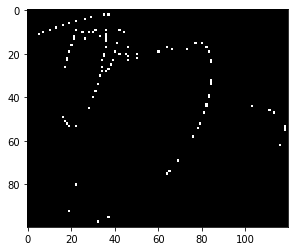

In [0]:
show_img(X_train[4,1,:,:,0])

#@title model diagram


add a @ to [model diagram] later to show
[model diagram](https://drive.google.com/uc?id=16-4s61R1rnkn3l8gS3ESLCO_2QMERIhm)

In [0]:
steven_model.save_weights('steven.h5')

In [0]:
steven_model.load_weights('steven.h5')

In [0]:
pred = steven_model.predict([x_test[:,0], x_test[:,1]])

In [0]:
pred = [0 if x < 0.5 else 1 for x in pred]

In [0]:
count = 0
for y in range(y_test.shape[0]):
  if y_test[y] == pred[y]:
    count = count +1 

print(count/len(pred))

0.5112


In [0]:
a = pred.ravel().tolist()
b = y_test.ravel().tolist()
for x in range(10):
  print(a[x], b[x])

0.006531731691211462 0.0
0.008064663037657738 0.0
0.006211492698639631 0.0
0.006309887859970331 1.0
0.004663524217903614 1.0
0.008866881020367146 0.0
0.006197284907102585 0.0
0.011134029366075993 1.0
0.010291756130754948 1.0
0.009998097084462643 0.0


In [0]:
def compute_accuracy(pred, y_test):
    return y_test[pred.ravel() < 0.5].mean() 

In [0]:
compute_accuracy(pred, y_test)

NameError: ignored

In [0]:
def display_triplet(tripletbatch):
  nrows = tripletbatch[0].shape[0]

  for x in range(len(tripletbatch[0])):
    fig = plt.figure(figsize=(27, 9*len(tripletbatch)))
    for i in range(3):
      sub = fig.add_subplot(3,9, i+1)
      plt.axis("off")
      plt.imshow(tripletbatch[i][x], cmap = "gray" )
      sub.title.set_text(labels[i])


In [0]:
def return_labels(pred):
  a = pred.ravel()
  ret = []
  for x in range(len(a)):
    if a[x] < 0.5:
      ret.append("forgery")
    else:
      ret.append("real")
  return ret

In [0]:
def show_predictions(x_test, y_test, pred, num_show):
  pred_labels = return_labels(pred)
  ref_labels = return_labels(y_test)
  for i in range(num_show):
    print(i)
    i = np.random.randint(0, pred.shape[0])
    fig = plt.figure(figsize = (50,25))
    for y in range(2):
      print(y)
      sub = fig.add_subplot(25,25,i+1)
      plt.axis("off")
      plt.imshow(x_test[y][i], cmap = "gray")
      title = str("LEFT: REFERENCE, RIGHT: QUESTIONED. PREDICTION:" + pred_labels[i] + "REFERENCE:" + ref_labels[i]) 
      sub.title.set_text(title)

      

In [0]:
show_predictions(x_test, y_test, pred, 10)

In [0]:
history = steven_model.fit(x=[X_train[:,0], X_train[:,1]], y = Y_train, 
                 epochs = num_iterations, verbose = 1, steps_per_epoch= int(np.abs(np.ceil(num_iterations/num_batch))))

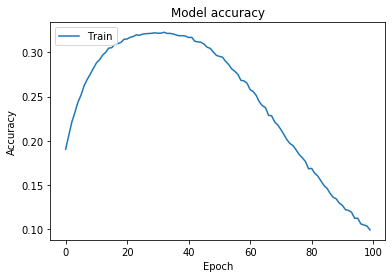

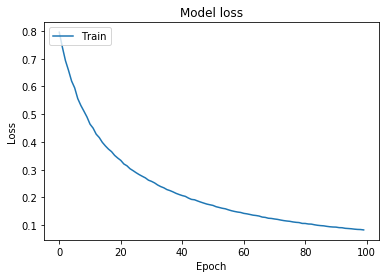

In [0]:
plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
#@title oldtrain!

train_datagen = keras.preprocessing.image.ImageDataGenerator(
  shear_range = 0.2,
  zoom_range = 0.2, 
)

train_generator1 = train_datagen.flow_from_directory(
    directory = "/content/drive/My Drive/Dataset_4NSigComp2010/ProcessedTrainingSet",
    batch_size = num_batch,
    color_mode = "grayscale",
    target_size = shape[0:2],
    shuffle = True,
    class_mode = "binary",
)

train_generator2 = train_datagen.flow_from_directory(
    directory = "/content/drive/My Drive/Dataset_4NSigComp2010/ProcessedTrainingSet",
    batch_size = num_batch,
    color_mode = "grayscale",
    target_size = shape[0:2],
    shuffle = True,
    class_mode = "binary",
)

#dual_train_generator = double_gen(train_generator1, train_generator2)

dual_train_generator = double_generator(train_generator1, train_generator2)

steven_model.fit_generator(dual_train_generator,use_multiprocessing= True, epochs = num_iterations,
                           verbose = 1, steps_per_epoch= int(np.abs(np.ceil(num_iterations/num_batch))))


In [0]:
def square_distance(xandy):
  x,y=xandy
  return backend.sqrt(backend.sum(backend.square(x - y), axis=1, keepdims=True))

In [0]:
def square_distance_shape(shapes):
  shape1, shape2 = shapes
  return (shape1[0], 1)

In [0]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return backend.mean(y_true * backend.square(y_pred) + (1 - y_true) * backend.square(backend.maximum(margin - y_pred, 0)))


In [0]:
#main

steven = create_network(shape)
steven.summary()

input_1 = Input(shape=shape)
input_2 = Input(shape=shape)

network_1 = steven(input_1)
network_2 = steven(input_2)

adam = keras.optimizers.adam(lr = learning_rate)
rms = keras.optimizers.RMSprop(lr = learning_rate)
distance = Lambda(square_distance, output_shape=square_distance_shape)([network_1, network_2])

steven_model = Model(input=[input_1, input_2], output = distance)

steven_model.compile(loss = contrastive_loss , optimizer = rms , metrics = ["accuracy"])

steven_model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 91, 111, 64)       6464      
_________________________________________________________________
batch_normalization_4 (Batch (None, 91, 111, 64)       256       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 91, 111, 64)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 55, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 45, 55, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 39, 49, 128)       401536    
_________________________________________________________________
batch_normalization_5 (Batch (None, 39, 49, 128)      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("la...)`
  from ipykernel import kernelapp as app
